In [33]:
import networkx as nx
import random
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import copy

import dimod
import dwave
import dwave.system
import plotly.graph_objects as go

from itertools import product

In [4]:
def generate_random_instance(n_machine, n_job, max_duration, timespan):

    instance = {}
    machine_list = list(range(n_machine))

    for i in range(n_job):
        random.shuffle(machine_list)
        instance[i] = []
        for j in range(n_machine):
            instance[i].append((machine_list[j], random.randint(1,max_duration)))
    instance['timespan'] = timespan
    
    return instance

In [402]:
n_jobs = 3
n_machines = 3
max_duration = 2
timespan = 10

instance = generate_random_instance(n_machines, n_jobs, max_duration, timespan)
instance

{0: [(1, 2), (2, 2), (0, 2)],
 1: [(2, 2), (0, 1), (1, 2)],
 2: [(0, 2), (2, 1), (1, 2)],
 'timespan': 10}

In [6]:
def get_variables(instance):

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1

    variables = np.zeros((n_machines, n_jobs, instance['timespan']))
    
    return variables


In [161]:
def build_graph(instance):
    graph = nx.Graph()
    job_groups = {}

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    for j in range(n_jobs):
        x = 1/4*j
        job_groups[j] = []
        for m in range(n_machines):
            x += 1
            for t in range(timespan):
                  y=(timespan-t)/3
                  graph.add_node((m,j,t), pos=[x,y])
                  job_groups[j].append((m,j,t))

    task_groups = {}

    m_seq = {}

    for job in range(n_jobs):
        m_seq[job] = []
        for task in instance[job]:
                m_seq[job].append(task[0])

    for job in m_seq:
        task_groups[job] = []
        
        for m in m_seq[job]:
                tmp = []

                for node in job_groups[job]:
                    if m == node[0]:
                            tmp.append(node)

                task_groups[job].append(tmp)


    pos_dict = {}

    for n in graph.nodes:
        pos_dict[n] = graph.nodes[n]['pos']


    return graph, task_groups, pos_dict

In [403]:
graph, task_groups, pos_dict = build_graph(instance)

In [10]:
def soo_edges(instance):
    curved_edges = []
    straight_edges = []

    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    
    for m in range(n_machines):
        for j in range(n_jobs):
            for t in range(timespan-1):
                for k in range(t+1,timespan):
                    if abs(t-k) > 1:
                        curved_edges.append(((m,j,t),(m,j,k)))
                    else:
                        straight_edges.append(((m,j,t),(m,j,k)))
    
    return curved_edges, straight_edges

In [398]:
def oo_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for job in range(n_jobs):
        for i in range(n_machines-1):
            task = instance[job][i]
            m = task[0]
            p = task[1]
            for t in range(timespan):
                t_max = t + p
                for t_p in range(t_max):
                    task_p = instance[job][i+1]
                    m_p = task_p[0]
                    p_p = task_p[1]

                    edges.append(((m,job,t),(m_p,job,t_p)))
        
    return edges

In [323]:
def I_set(instance,m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_m = set()
    for job in range(n_jobs):
        for task in instance[job]:
            if task[0] == m:
                I_m.add((m,job))
    I_mx = set(product(I_m, repeat=2))

    rm_list = []
    for e in I_mx:
        if e[0] == e[1]:
            rm_list.append(e)
    for r in rm_list:
        I_mx.remove(r)
    '''
    tmp = list(I_mx)
    for e in tmp:
        if (e[1], e[0]) in I_mx:
            I_mx.remove(e)
    '''
            
    return I_mx

In [406]:
def A_set(instance, m):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']

    I_mx = I_set(instance, m)

    A_m = set()

    for e in I_mx:
        
        job = e[0][1]
        for t in instance[job]:
            if t[0] == m:
                p = t[1]
        
        for t in range(timespan):
            for t_p in range(timespan):
                if (0<=t_p - t) and (t_p-t<p):
                    new_el = ((e[0][0], e[0][1], t), (e[1][0], e[1][1], t_p))
                    A_m.add(new_el)
    return A_m
    


In [44]:
def otm_edges(instance):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    edges = []

    for m in range(n_machines):
        R_m = A_set(instance, m)
        for e in R_m:
            edges.append((e[0], e[1]))
    
    return edges

In [407]:
otm_straight = otm_edges(instance)

In [408]:
soo_curved, soo_straight = soo_edges(instance)

In [409]:
oo_straight = oo_edges(instance)

In [410]:
len(oo_straight)

370

In [411]:
graph.add_edges_from(soo_curved)
graph.add_edges_from(soo_straight)

In [412]:
graph.add_edges_from(oo_straight)

In [413]:
graph.add_edges_from(otm_straight)

In [425]:
def simple_pruning(instance, graph, pos_dict, task_groups, edge_groups):
    n_machines = len(instance[0])
    n_jobs = len(instance.keys())-1
    timespan = instance['timespan']
    graph = copy.deepcopy(graph)

    ext_instance = copy.deepcopy(instance)
    edge_groups = copy.deepcopy(edge_groups)

    #head and tail comp
    for job in range(n_jobs):
        for t_idx,task in enumerate(instance[job]):
            p_task = task[1]
            m_task = task[0]
            #single job upperbound
            tail = timespan
            for i in range(t_idx, n_machines):
                tail -= instance[job][i][1]

            #single job lowerbuond
            head = 0
            for i in range(t_idx):
                head += instance[job][i][1]

            ext_instance[job][t_idx] += (head,tail)
    
    tmp_instance = copy.deepcopy(ext_instance)
    '''
    #single machine upperbound
    for job in range(n_jobs):
        for task_idx, task in enumerate(ext_instance[job]):
            m_task = task[0]
            for j in range(n_jobs):
                for t in ext_instance[job]:
                    if (m_task == t[0]) and (task[2] + task[1] + t[1] + t[3] > timespan):
                        tmp = list(tmp_instance[job][task_idx])
                        tmp[2] = max(task[2], t[2]+t[1])
                        tmp_instance[job][task_idx] = tuple(tmp)
    '''
    ext_instance = tmp_instance
    
    rm_nodes = []
    for job in range(n_jobs):
        for task in ext_instance[job]:

            #node removal
            for node in graph.nodes:
                if (node[0] == task[0]) and (node[1] == job) and ((node[2] < task[2] ) or (node[2] > task[3])):
                    rm_nodes.append(node)
    for r in rm_nodes:
        graph.remove_node(r)

    #edge removal
    rm_edges = []
    for edge in graph.nodes:
        for r in rm_nodes:
            if r in edge:
                rm_edges.append(edge)
    for r in rm_edges:
        graph.remove_edge(r)

    #pos removal
    rm_pos = []
    for k in pos_dict:
        if k in rm_nodes:
            rm_pos.append(k)
    for r in rm_pos:
        del pos_dict[r]

    #node groups removal
    for j in task_groups:
        for  i,g in enumerate(task_groups[j]):
            rm_task = []
            for n in g:
                if n in rm_nodes:
                    rm_task.append(n)
            for r in rm_task:
                task_groups[j][i].remove(r)

    #edge groups removal
    for i,group in enumerate(edge_groups):
        rm_edgegroup = []
        
        for edge in group:
            for node in rm_nodes:
                if (node in edge) and (edge not in rm_edgegroup):
                    rm_edgegroup.append(edge)
        for r in rm_edgegroup:
            edge_groups[i].remove(r)
    
    return graph, ext_instance, pos_dict, task_groups, edge_groups

In [426]:
edge_groups = [soo_curved, soo_straight, otm_straight, oo_straight]

graph2, ext_instance, pos_dict2, task_groups2, edge_groups2 = simple_pruning(instance, graph, pos_dict, task_groups, edge_groups)

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


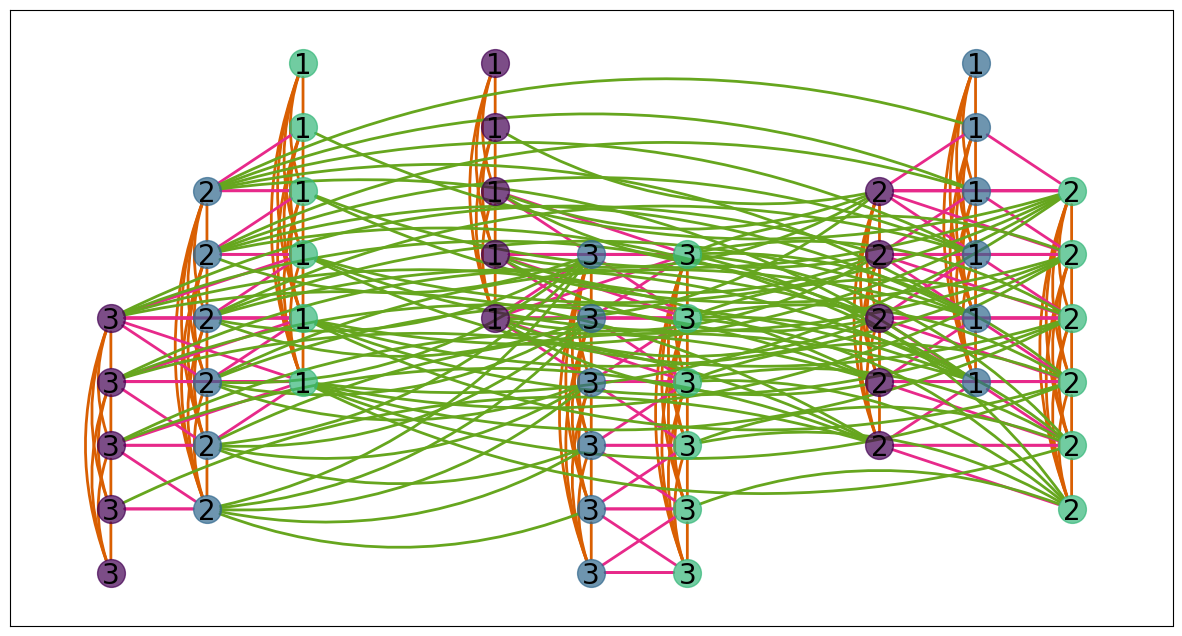

In [427]:
plt.figure(figsize=(15,8))
cmap_nodes = matplotlib.colormaps.get_cmap('viridis')
cmap_edges = matplotlib.colormaps.get_cmap('Dark2')
linewidth = 2
node_size = 400
node_alpha = 0.7
edge_alpha = 1


for job in task_groups2:
    for i,task in enumerate(task_groups2[job]):
        nx.draw_networkx_nodes(graph2, pos_dict2, node_size=node_size, nodelist=task, node_color=cmap_nodes(job/len(task_groups)), alpha=node_alpha)

        labels = dict(zip(task, [str(i+1) for j in range(len(task))]))
        nx.draw_networkx_labels(graph, pos_dict2, labels, font_size=20, verticalalignment='center_baseline')
        
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[0], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[1], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.2))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[2], arrows=True, connectionstyle="arc3", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.4))
nx.draw_networkx_edges(graph2, pos_dict2, node_size=node_size, edgelist=edge_groups2[3], arrows=True, connectionstyle="arc3,rad=0.2", width=linewidth, alpha=edge_alpha, edge_color=cmap_edges(0.6))


plt.show()